In [208]:
import requests  
from bs4 import BeautifulSoup
from datetime import datetime
from time import sleep
import pandas as pd
import fake_useragent
from fake_useragent import UserAgent
import random
from tqdm import tqdm

## Парсинг сайта ##

In [108]:
cars_data = pd.DataFrame()

In [109]:
for page in range(1, 21): # Задаем число просматриваемых страниц с объявлениями
    url = f'https://auto.ru/moskva/cars/used/?page={page}'
    response = requests.get(url, headers={'User-Agent': UserAgent().chrome})
    content = BeautifulSoup(response.content, 'html.parser')
    cars = content.find_all('div', {'class': 'ListingItem-module__description'})
    sleep(4.5 + random.random()) # Бездействуем, чтобы нас не забанили
    for car in tqdm(cars):
        try:
            car_info = dict() # Формирем словарь и информацией об автомобиле
            car_link = car.find('a', { 'class': ['Link', 'ListingItemTitle-module__link']}).get('href')
            response = requests.get(car_link, headers={'User-Agent': UserAgent().chrome})
            content = BeautifulSoup(response.content, 'html.parser')
            car_info['Link'] = car_link
            table = content.find_all('li', { 'class': 'CardInfoRow' })
            car_info['Title'] = content.find('h1').text.replace('\xa0', ' ')
            car_info['Price'] = content.find('span', 'OfferPriceCaption__price').text.replace('\xa0', ' ')
            car_info['Mark'] = content.find('div', {'class': ['InfoPopup','InfoPopup_theme_plain','InfoPopup_withChildren','BreadcrumbsPopup-module__BreadcrumbsPopup']}).find('a', { 'class': ['Link','Link_color_gray','CardBreadcrumbs__itemText']}).text.replace('\xa0', ' ')
            car_info['Placement_date'] = content.find('div', { 'class' : ['lgkqdBtNZnmDcmU0rHpEj__info-item']}).text.replace('\xa0', ' ')
            car_info['Views'] = content.find('div', { 'class' : ['lgkqdBtNZnmDcmU0rHpEj__info-item','lgkqdBtNZnmDcmU0rHpEj__views'], 'title' : 'Количество просмотров'}).text.replace('\xa0', ' ')
            for raw in table: 
                car_info[raw.find_all('span')[0].text] = raw.find_all('span')[1].text.replace('\xa0', ' ')
            sleep(4.5 + random.random())
            cars_data = cars_data.append(car_info, ignore_index=True) # Добавляем информацию об авто в датафрейм
        except:
            sleep(4.5 + random.random())
            continue

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [18:20<00:00, 28.95s/it]


SSLError: HTTPSConnectionPool(host='auto.ru', port=443): Max retries exceeded with url: /moskva/cars/used/?page=15 (Caused by SSLError(SSLCertVerificationError("hostname 'auto.ru' doesn't match either of '*.beeline.ru', 'beeline.ru'")))

In [112]:
cars_data.shape # Смотрим на число автомобилей и признаков

(360, 26)

In [115]:
cars_data.to_csv('cars_data.csv', index=False, sep='\t') # На всякий пожарный сохраняем в файл

## Обработка данных ##

In [440]:
cars_data1 = pd.read_csv('cars_data.csv',delimiter='\t') 
cars_data1.head(2)

,Link,Mark,Placement_date,Price,Title,VIN,Views,Владельцы,Госномер,Двигатель,...,Руль,Состояние,Таможня,Цвет,год выпуска,Владение,Кузов №,Обмен,Гарантия,Запас хода
0,https://auto.ru/cars/used/sale/volvo/s40/11033...,Volvo,1 июня,230 000 ₽,Volvo S40 I Рестайлинг,YV1**************,435 (116 сегодня),3 или более,******|152,1.8 л / 122 л.с. / Бензин,...,Левый,Не требует ремонта,Растаможен,серый,2002,NaN,NaN,NaN,NaN,NaN
1,https://auto.ru/cars/used/sale/hyundai/i40/110...,Hyundai,26 мая,1 130 000 ₽,Hyundai i40 I Рестайлинг,XWE**************,582 (66 сегодня),2 владельца,******|777,2.0 л / 150 л.с. / Бензин,...,Левый,Не требует ремонта,Растаможен,коричневый,2016,NaN,NaN,NaN,NaN,NaN


Смотрим в каких столбцах есть пропуски

In [441]:
cars_data1.isna().sum()

Link                0
Mark                0
Placement_date      0
Price               0
Title               0
VIN                 3
Views               0
Владельцы           0
Госномер          268
Двигатель           0
Коробка             0
Кузов               0
Налог               7
ПТС                 0
Привод              0
Пробег              0
Руль                0
Состояние           0
Таможня             0
Цвет                0
год выпуска         0
Владение          300
Кузов №           358
Обмен             131
Гарантия          304
Запас хода        355
dtype: int64

Удаляем столбцы, в которых слишком много пропусков

In [442]:
drop_list = list() 
for i in range(len(cars_data1.isna().sum().values)):
    if cars_data1.isna().sum().values[i] / cars_data1.shape[0] > 0.7:
        drop_list.append(cars_data1.isna().sum().index[i])
cars_data1.drop(columns=drop_list, inplace=True)
drop_list

['Госномер', 'Владение', 'Кузов №', 'Гарантия', 'Запас хода']

Корректируем столбцы, где хранятся числовые данные

In [443]:
def money_correcter(raw):
    try:
        raw = raw.replace(' ', '')
        raw = raw[:raw.find('₽')]
        return raw
    except:
        return raw

def probeg_correcter(raw):
    try:
        raw = raw.replace(' ', '')
        raw = raw[:raw.find('км')]
        return raw
    except:
        return raw

In [444]:
cars_data1['Налог'] = cars_data1['Налог'].apply(money_correcter)
cars_data1['Price'] = cars_data1['Price'].apply(money_correcter)
cars_data1['Пробег'] = cars_data1['Пробег'].apply(probeg_correcter)

In [445]:
cars_data1['Налог'] = pd.to_numeric(cars_data1['Налог'])
cars_data1['Price'] = pd.to_numeric(cars_data1['Price'])
cars_data1['год выпуска'] = pd.to_numeric(cars_data1['год выпуска'])
cars_data1['Пробег'] = pd.to_numeric(cars_data1['Пробег'])

Оставшиеся пропуски заполняем

Вин заменим пустыми строками

In [446]:
cars_data1['VIN'] = cars_data1['VIN'].fillna('')

Налог на среднее значение

In [447]:
cars_data1['Налог'] = cars_data1['Налог'].fillna(cars_data1['Налог'].mean())

Обмен на самое частовстречаемое значение

In [525]:
cars_data1["Обмен"].fillna(cars_data1['Обмен'].value_counts().index[0], inplace = True)

Пропусков стало меньше

In [526]:
cars_data1.isna().sum()

Link              0
Mark              0
Placement_date    0
Price             0
Title             0
VIN               0
Views             0
Владельцы         0
Двигатель         0
Коробка           0
Кузов             0
Налог             0
ПТС               0
Привод            0
Пробег            0
Руль              0
Состояние         0
Таможня           0
Цвет              0
год выпуска       0
Обмен             0
Возраст           0
Пробег за год     0
Total views       0
dtype: int64

## Новые признаки ##

In [471]:
def age_definer(car_year):
    current_year = datetime.now().timetuple()[0]
    if current_year - car_year < 3:
        return 'Новая'
    if current_year - car_year < 6:
        return 'Средняя'
    else:
        return 'Старая'

def km_per_year(car_year, car_mileage):
    try:
        current_year = datetime.now().timetuple()[0]
        return car_mileage // (current_year - car_year + 1)
    except:
        return None

def total_views_definer(raw):
    try:
        return raw[:raw.find(' ')]
    except:
        return None

Присваиваем категории возраста для автомобиля

In [450]:
cars_data1['Возраст'] = cars_data1['год выпуска'].apply(age_definer)
cars_data1['Возраст'][:6]

0     Старая
1    Средняя
2     Старая
3     Старая
4    Средняя
5      Новая
Name: Возраст, dtype: object

Присваем категорию сколько автомобиль ездил в среднем за год своего существования

In [451]:
cars_data1['Пробег за год'] = cars_data1[['год выпуска','Пробег']].apply(lambda x: km_per_year(*x), axis=1)
cars_data1['Пробег за год'][:6]

0    18000
1    13550
2      416
3     8666
4     4200
5       10
Name: Пробег за год, dtype: int64

Делаем категорию с общим числов просмотров автомобиля (до этого в столбце было строка вида *435 (116 сегодня)*)

In [473]:
cars_data1['Total views'] = pd.to_numeric(cars_data1['Views'].apply(total_views_definer))
cars_data1['Total views'][:6]

0     435
1     582
2     754
3    2462
4       3
5       1
Name: Total views, dtype: int64

## Графики ##

In [452]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Сделаем график распределения машин по возрастным категориям в рамках фирмы. 
Построим для топ 3 фирм по числу объявлений, чтобы не нагромождать график.

In [453]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

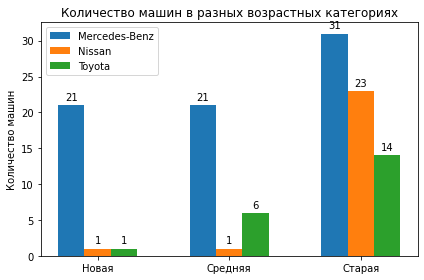

In [457]:
ser = cars_data1['Mark'].value_counts()
mark_list = ser.iloc[:3].index.tolist()
grouped_data = cars_data1[cars_data1['Mark'].isin(mark_list)].groupby(['Mark', 'Возраст']).size()

all_marks = grouped_data.to_frame().reset_index()
first_mark = all_marks[all_marks['Mark'] == ser.iloc[:3].index.tolist()[0]]
second_mark = all_marks[all_marks['Mark'] == ser.iloc[:3].index.tolist()[1]]
third_mark = all_marks[all_marks['Mark'] == ser.iloc[:3].index.tolist()[2]]

first_name = first_mark['Mark'].values[0]
second_name = second_mark['Mark'].values[0]
third_name = third_mark['Mark'].values[0]

labels = first_mark['Возраст'].tolist()

first_mark = first_mark[0].tolist()
second_mark = second_mark[0].tolist()
third_mark = third_mark[0].tolist()


x = np.arange(len(labels))
width = 0.2 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, first_mark, width, label=first_name)
rects2 = ax.bar(x, second_mark, width, label=second_name)
rects3 = ax.bar(x + width, third_mark, width, label=third_name)

ax.set_ylabel('Количество машин')
ax.set_title('Количество машин в разных возрастных категориях')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

Посмотрим, какую долю объвлений занимает каждая фирма автомобилей. 
Подпишем в процентном соотношении, предварительно удалив те, у которых доля объявлений меньше 3% от общего числа, чтобы не нагромождать график

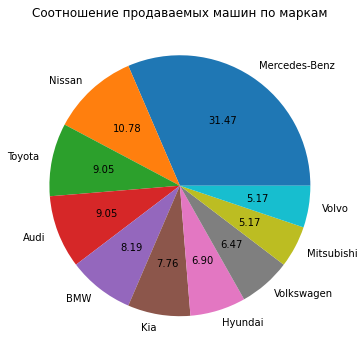

In [458]:
cars_data1['Mark'].value_counts().loc[lambda ser: ser / cars_data1.shape[0] > 0.03].plot.pie(label="", title="Соотношение продаваемых машин по маркам", autopct='%.2f', figsize=(6, 6));

## Группировки

Распределение по возрастным категориям для топ 5 фирм по числу объявлений, чтобы не нагромождать вывод

In [461]:
ser = cars_data1['Mark'].value_counts()
mark_list = ser.iloc[:5].index.tolist()
grouped_data = cars_data1[cars_data1['Mark'].isin(mark_list)].groupby(['Mark', 'Возраст']).size()
grouped_data

Mark           Возраст
Audi           Новая       2
               Средняя     4
               Старая     15
BMW            Новая       7
               Средняя     5
               Старая      7
Mercedes-Benz  Новая      21
               Средняя    21
               Старая     31
Nissan         Новая       1
               Средняя     1
               Старая     23
Toyota         Новая       1
               Средняя     6
               Старая     14
dtype: int64

Посмотрим информацию по пробегу за год для всех автомобилей

In [462]:
cars_data1['Пробег за год'].describe()

count      360.000000
mean     10997.636111
std       5776.515145
min          7.000000
25%       7455.250000
50%      10851.500000
75%      14264.750000
max      43750.000000
Name: Пробег за год, dtype: float64

Посмотрим зависимость пробега машины от числа ее владельцев

In [465]:
cars_data1.groupby(['Владельцы']).mean()['Пробег']

Владельцы
1 владелец      71355.220690
2 владельца     95178.633929
3 или более    119039.427184
Name: Пробег, dtype: float64

Как видно, чем больше владельцев было у машины, тем больше ее пробег

Посмотрим на зависимости состояния машины от числа ее владельцев

In [466]:
cars_data1.groupby(['Владельцы', 'Состояние']).size()

Владельцы    Состояние         
1 владелец   Не требует ремонта    145
2 владельца  Не требует ремонта    112
3 или более  Не требует ремонта    103
dtype: int64

Эти данные ничего нам не дали

Посмотрим на общее число просмотров объявлений в рамках фирмы. Вывели топ 5, чтобы не нагромождать вывод

In [516]:
ser = cars_data1['Mark'].value_counts()
mark_list = ser.iloc[:5].index.tolist()
grouped_data = cars_data1[cars_data1['Mark'].isin(mark_list)].groupby(['Mark']).sum()['Total views'].sort_values(ascending=False)
grouped_data

Mark
Mercedes-Benz    16888
Nissan           11965
BMW               6120
Audi              6031
Toyota            4461
Name: Total views, dtype: int64

Как видно, мерседес сильно лидирует
Посмотрим также в процентах

In [517]:
grouped_data.to_frame()['Total views'] / grouped_data.sum() * 100

Mark
Mercedes-Benz    37.145057
Nissan           26.316947
BMW              13.460904
Audi             13.265149
Toyota            9.811943
Name: Total views, dtype: float64

Как видно, более трети объявлений приходится на мерседес!